<a href="https://colab.research.google.com/github/shreyas-muralidhara/Bitcoin-price-prediction/blob/main/Bitcoin_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Bitcoin price prediction - Team 6

### Neural Network and Deep Learning - ECE542/CSC591
### Final Project - Spring 2020 
### Team Members (Project Team 6):

Shreyas Chikkballapur Muralidhara - schikkb                        

Aditya Kadole - akadole

Shrihari Sundararaj - ssunda23 


### Data preprocessing during runtime

mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Copying bitcoin data from Drive

In [ ]:
# Remove the old files if the exist
!rm -rf bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv.zip 
!rm -rf bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv

!cp /content/drive/My\ Drive/Neural_projF/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv.zip /content
!unzip -q bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv.zip 

### Import libraries

In [ ]:
# Import the necessary libraries to implement the model
#!pip install tensorflow==1.14.0
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import operator
import keras
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Read the dataset
file_name = "bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv"
input_df = pd.read_csv(file_name, delimiter=',')

# Typecast timestamp to Date time format
input_df['Timestamp'] = pd.to_datetime(input_df.Timestamp, unit='s')
input_df = input_df.reindex()
print(input_df.head(5), input_df.tail(5))
print(input_df.shape)

Using TensorFlow backend.


            Timestamp  Open  ...  Volume_(Currency)  Weighted_Price
0 2011-12-31 07:52:00  4.39  ...                2.0            4.39
1 2011-12-31 07:53:00   NaN  ...                NaN             NaN
2 2011-12-31 07:54:00   NaN  ...                NaN             NaN
3 2011-12-31 07:55:00   NaN  ...                NaN             NaN
4 2011-12-31 07:56:00   NaN  ...                NaN             NaN

[5 rows x 8 columns]                   Timestamp     Open  ...  Volume_(Currency)  Weighted_Price
4363452 2020-04-21 23:56:00  6847.97  ...         858.128697     6855.498790
4363453 2020-04-21 23:57:00  6850.23  ...        8396.781459     6855.763449
4363454 2020-04-21 23:58:00  6846.50  ...       48533.089069     6846.090966
4363455 2020-04-21 23:59:00  6854.18  ...          83.831604     6854.195090
4363456 2020-04-22 00:00:00  6850.60  ...          98.896906     6850.600000

[5 rows x 8 columns]
(4363457, 8)


### Impute mean values to generate transactions at day, week and month frequency

In [ ]:
# Based on Date field, impute mean values to generate mean on daily frequency
input_day_df = input_df
input_day_df.index = input_day_df.Timestamp
input_day_df = input_day_df.resample('D').mean().reset_index()
#print(input_day_df.shape)

# Remove null values if any daily frequency
if input_day_df.isna().values.any():
  input_day_df = input_day_df.dropna()


# Based on Date field, impute mean values to generate mean on weekly frequency
input_week_df = input_df
input_week_df.index = input_week_df.Timestamp
input_week_df = input_week_df.resample('W').mean().reset_index()
#print(input_week_df.shape)

# Remove null values if any week frequency
if input_week_df.isna().values.any():
  input_week_df = input_week_df.dropna()


# Based on Date field, impute mean values to generate mean on monthly frequency
input_month_df = input_df
input_month_df.index = input_month_df.Timestamp
input_month_df = input_month_df.resample('M').mean().reset_index()
#print(input_month_df.shape)

# Remove null values if any week frequency
if input_month_df.isna().values.any():
  input_month_df = input_month_df.dropna()


print(input_day_df.shape, input_week_df.shape, input_month_df.shape)

(3033, 8) (435, 8) (101, 8)


### Split the data to test and train and Plot the weighted price daily trend

Dimension of train data is (2426, 8)
Dimension of test data is (707, 8)


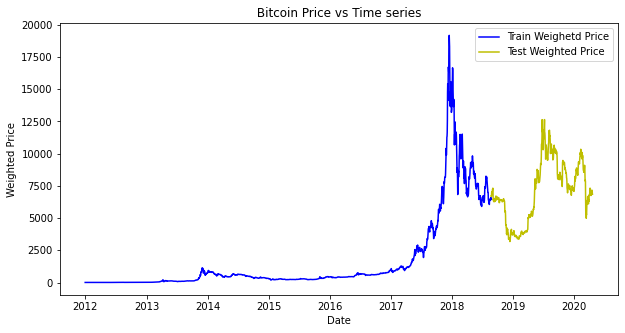

In [ ]:
# Split the data as train and test
train_size = 0.80
prev_val = 100

day_train_df = input_day_df.iloc[:round(input_day_df.shape[0]*train_size),:]
day_test_df = input_day_df.iloc[round(input_day_df.shape[0]*train_size)-prev_val:,:]

print('Dimension of train data is',day_train_df.shape)
print('Dimension of test data is',day_test_df.shape)

# Plot Bitcoin price
plt.figure(figsize=(10,5),facecolor =  'white')
plt.plot(day_train_df.iloc[:,0], day_train_df.iloc[:,-1],'b', label="Train Weighetd Price")
plt.plot(day_test_df.iloc[prev_val:,0], day_test_df.iloc[prev_val:,-1],'y', label="Test Weighted Price")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Weighted Price")
plt.title(" Bitcoin Price vs Time series ")
plt.show()

### Weighted Price Stationarity check for forecasting Time series
Reference - https://towardsdatascience.com/detecting-stationarity-in-time-series-data-d29e0a21e638

  * Parameters tests - Augmented Dickey Fuller Test
  * Autocorelation function plot - partial and complete 
  * Visualization - trend and Seasonality 

#### Unit root test - Augmented Dickey Fuller Test 

In [ ]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(day_train_df['Weighted_Price'])
print('ADF statistic for train data -', round(res[0],4))
print('MacKinnon’s approximate p-value for train data -', round(res[1],4))

ADF statistic for train data - -1.5871
MacKinnon’s approximate p-value for train data - 0.4901


#### Visualize Seasonality and trends 

Below is the seasonal decomposition for additive model



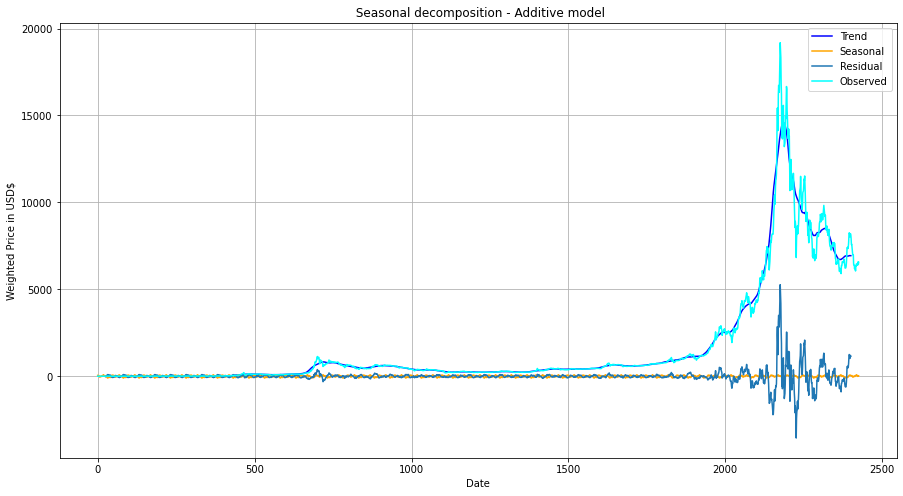

In [ ]:
import statsmodels.api as sm

# Seasonal Additive Model
s = sm.tsa.seasonal_decompose(day_train_df["Weighted_Price"].values, model="additive", freq=60)

print("Below is the seasonal decomposition for additive model\n")

plt.figure(figsize=(15,8),facecolor = 'white')
plt.plot(np.arange(0, len(s.trend), 1), s.trend,'blue', label="Trend")
plt.plot(np.arange(0, len(s.seasonal), 1), s.seasonal,'orange', label="Seasonal")
plt.plot(np.arange(0, len(s.resid), 1), s.resid,label="Residual")
plt.plot(np.arange(0, len(s.observed), 1), s.observed,'cyan', label="Observed")
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Weighted Price in USD$")
plt.title(" Seasonal decomposition - Additive model")
plt.grid()

#### Autocorelation function plot

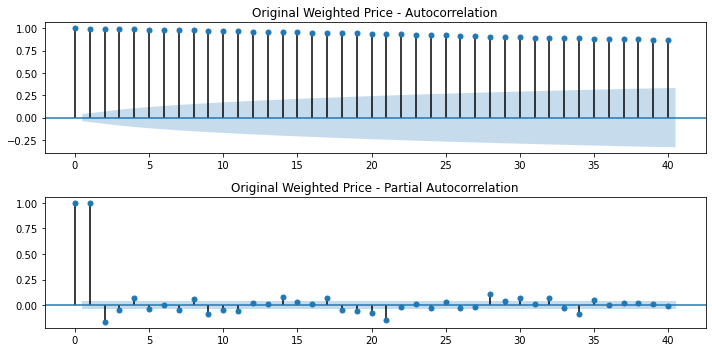

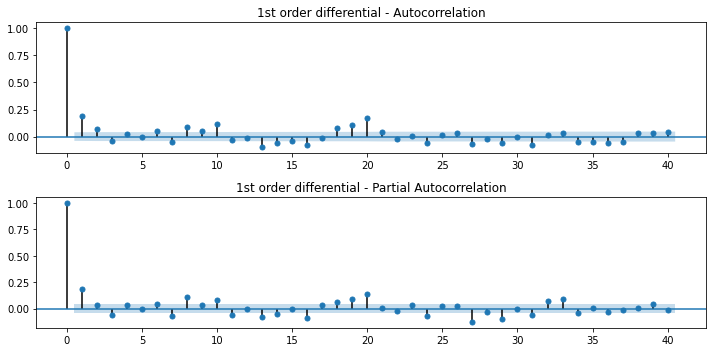

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot for original Weighted Price
plt.figure(figsize=(10,5),facecolor='white')
ax = plt.subplot(211)
plot_acf(day_train_df["Weighted_Price"].values,lags=40, ax=ax,title='Original Weighted Price - Autocorrelation')
ax = plt.subplot(212)
plot_pacf(day_train_df["Weighted_Price"].values, lags=40, ax=ax,title='Original Weighted Price - Partial Autocorrelation')
plt.tight_layout()
plt.show()

# Plot for 1st order differencial
plt.figure(figsize=(10,5),facecolor='white')
ax = plt.subplot(211)
plot_acf(day_train_df["Weighted_Price"].diff().dropna().values,lags=40, ax=ax, title='1st order differential - Autocorrelation')
ax = plt.subplot(212)
plot_pacf(day_train_df["Weighted_Price"].diff().dropna().values, lags=40, ax=ax, title='1st order differential - Partial Autocorrelation')
plt.tight_layout()
plt.show()


#### Results from the 3 stationary checks performed:
 1. adfuller pvalue result for train set = 0.4901 > 0.05. we cannot rule out the null hypothesis. But due to low value of ADF statistic we cannot consider the result of data not being stationary.
 
 2. Seasonal decomposition trend for Season and Trend are same as residual and observed. Hence time series is stationary

 3. Autocorelation function plots to identify the order of differencing to make the time series stationary. Thus for the order of first differencial the time series is stationary as the values are closer to zero.


### Data Preprocessing with Sequence forecasting

In [ ]:
# Reshaping data
train_df = np.reshape(day_train_df['Weighted_Price'].values, (len(day_train_df['Weighted_Price'].values), 1))
test_df = np.reshape(day_test_df['Weighted_Price'].values, (len(day_test_df['Weighted_Price'].values), 1))

# rescaling the dataframes
scaler = MinMaxScaler()
train_df = scaler.fit_transform(train_df)
test_df = scaler.transform(test_df)


# Generate the Train dataset
X_train = []
y_train = []
for i in range(prev_val, len(train_df)):
    X_train.append(train_df[i-prev_val:i, -1])
    y_train.append(train_df[i,-1])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)


# Generate the Test dataset
X_test = []
y_test = []
for i in range(prev_val, len(test_df)):
    X_test.append(test_df[i-prev_val:i, -1])
    y_test.append(test_df[i,-1])
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)


(2326, 100) (2326,)
(607, 100) (607,)


#### Plot to confirm continuous sequence of test and train values. 

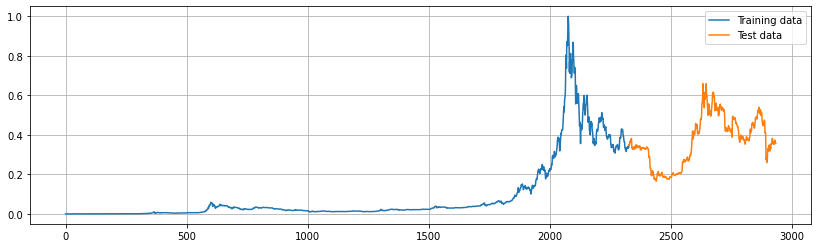

In [ ]:
plt.figure(figsize=(14,4), facecolor='white')
plt.plot(range(len(y_train)),y_train)
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test)
plt.legend(["Training data", "Test data"])
plt.grid()

#### Reshape the train and test data for the model

In [ ]:
#result
#X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1, X_test.shape[1],1)

print(X_train.shape,X_test.shape)

(2326, 100, 1) (607, 100, 1)


### LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow import keras

#### Define the model

In [ ]:
model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (100, 1), activation = 'relu'))
model.add(LSTM(256, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(X_test.shape[2]))
optimizer = 'adam'

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 100, 256)          264192    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 256)          525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25601     
Total params: 815,105
Trainable params: 815,105
Non-trainable params: 0
_________________________________________________________________


### delete model h5 files if experiment useless

In [ ]:
!rm *.h5;

rm: cannot remove '*.h5': No such file or directory


#### Train and save best validation accuracy checkpoint

In [ ]:
# Compile the model
model.compile(loss = 'mean_absolute_error' , optimizer=optimizer, metrics=['mae'])

batch_size= 16
no_epochs = 20

earlystop = EarlyStopping(monitor='val_mae', patience=20)
checkpoint = ModelCheckpoint('model-epoch-{epoch:03d}-valmae-{val_mae:03f}.h5', verbose=1, monitor='val_mae',save_best_only=True, mode='auto')

# Generate the fit model
hist = model.fit(X_train, y_train, 
                 epochs=no_epochs, 
                 batch_size=batch_size, 
                 validation_data=(X_test, y_test),
                 verbose=1,
                 callbacks=[earlystop, checkpoint])


Train on 2326 samples, validate on 607 samples
Epoch 1/20
2326/2326 [==============================] - 106s 46ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.1013 - val_mae: 0.1013

Epoch 00001: val_mae improved from inf to 0.10127, saving model to model-epoch-001-valmae-0.101273.h5
Epoch 2/20
2326/2326 [==============================] - 94s 41ms/step - loss: 0.0181 - mae: 0.0181 - val_loss: 0.0714 - val_mae: 0.0714

Epoch 00002: val_mae improved from 0.10127 to 0.07142, saving model to model-epoch-002-valmae-0.071417.h5
Epoch 3/20
2326/2326 [==============================] - 95s 41ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0441 - val_mae: 0.0441

Epoch 00003: val_mae improved from 0.07142 to 0.04412, saving model to model-epoch-003-valmae-0.044120.h5
Epoch 4/20
2326/2326 [==============================] - 95s 41ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0240 - val_mae: 0.0240

Epoch 00004: val_mae improved from 0.04412 to 0.02396, saving model to model-epoch-004-val

In [ ]:
!cp model-epoch-014-valmae-0.015990.h5 /content/drive/My\ Drive/Neural_projF/

#### Visualizing the training and validation loss along with mae

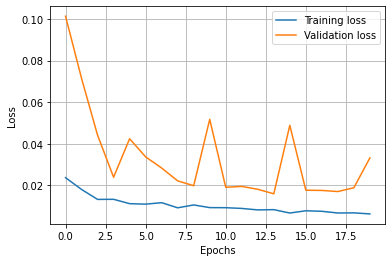

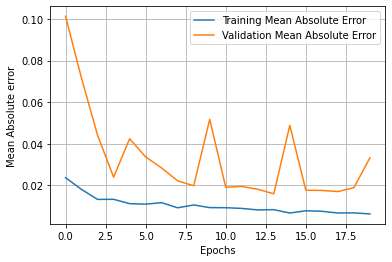

In [ ]:
#!cp /content/drive/My\ Drive/Neural_projF/hist_lstm_valmae_0.015990.npy /content/
#hist_val = np.load('/content/hist_lstm_valmae_0.015990.npy',allow_pickle=True)

sub=0
# visualizing losses and accuracy
train_loss = hist.history['loss'][sub:]
val_loss = hist.history['val_loss'][sub:]
train_mae = hist.history['mae'][sub:]
val_mae = hist.history['val_mae'][sub:]
xc = range(no_epochs)

plt.figure(facecolor='white')
plt.plot(xc, train_loss, label='Training loss')
plt.plot(xc, val_loss, label='Validation loss')
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

plt.figure(facecolor='white')
plt.plot(xc, train_mae, label='Training Mean Absolute Error')
plt.plot(xc, val_mae, label='Validation Mean Absolute Error')
plt.legend(loc="upper right")
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute error')
plt.grid()

### TEST MODEL

#### Test model on the test data

In [ ]:
# Load the saved model from the drive
!cp /content/drive/My\ Drive/Neural_projF/model-epoch-014-valmae-0.015990.h5 /content/

from keras.models import load_model

model = keras.models.load_model('model-epoch-014-valmae-0.015990.h5')
model.save('model-epoch-014-valmae-0.015990.h5')

y_pred = model.predict(X_test)


y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred2_inverse = np.array(y_pred_inverse[:,0])
y_test2_inverse = np.array(y_test_inverse[:,0])

print(y_pred_inverse.shape, y_test_inverse.shape)
print(y_pred2_inverse.shape, y_test2_inverse.shape)

(607, 1) (607, 1)
(607,) (607,)


#### Compute the Metric
  1. MSE - Mean Squared Error
  2. RMSE - Root Mean Squared Error
  3. MAE - Mean Absolute Error 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

result_MAE = mean_absolute_error(y_pred2_inverse, y_test2_inverse)
result_MSE = mean_squared_error(y_pred2_inverse, y_test2_inverse)
result_RMSE = math.sqrt(mean_squared_error(y_pred2_inverse, y_test2_inverse))

print('test data Mean Square Error - ',result_MSE)
print('Test data RMSE is ', result_RMSE)
print('Test data Mean Absolute error - ', result_MAE)

test data Mean Square Error -  196430.1359941975
Test data RMSE is  443.20439527851875
Test data Mean Absolute error -  306.7201199344436


Our best model has the Validation mean absolute error of 0.0159, with validation loss of 3.33%. 

On comparision of Prediction values with the test samples:
* **RMSE** - Provides an offset range for the actual value from the predicted value, indicating the extent of error.
So our predictions varies from the actual values by max of $443.23(USD) for a given prediction.

* **MAE** - Mean absolute error measures the average magniture of the errors in the test set predictions. It doesn't consider direction. It is average over the absolute difference between actual and predicted values, with each value given equal weightage.

So our predictions have mean absolute error $306.7202(USD) for the given set of test predictions.


#### Plotting the Weighted Price for Bitcoin - 25-Aug-2018 to 22-Apr-2020 

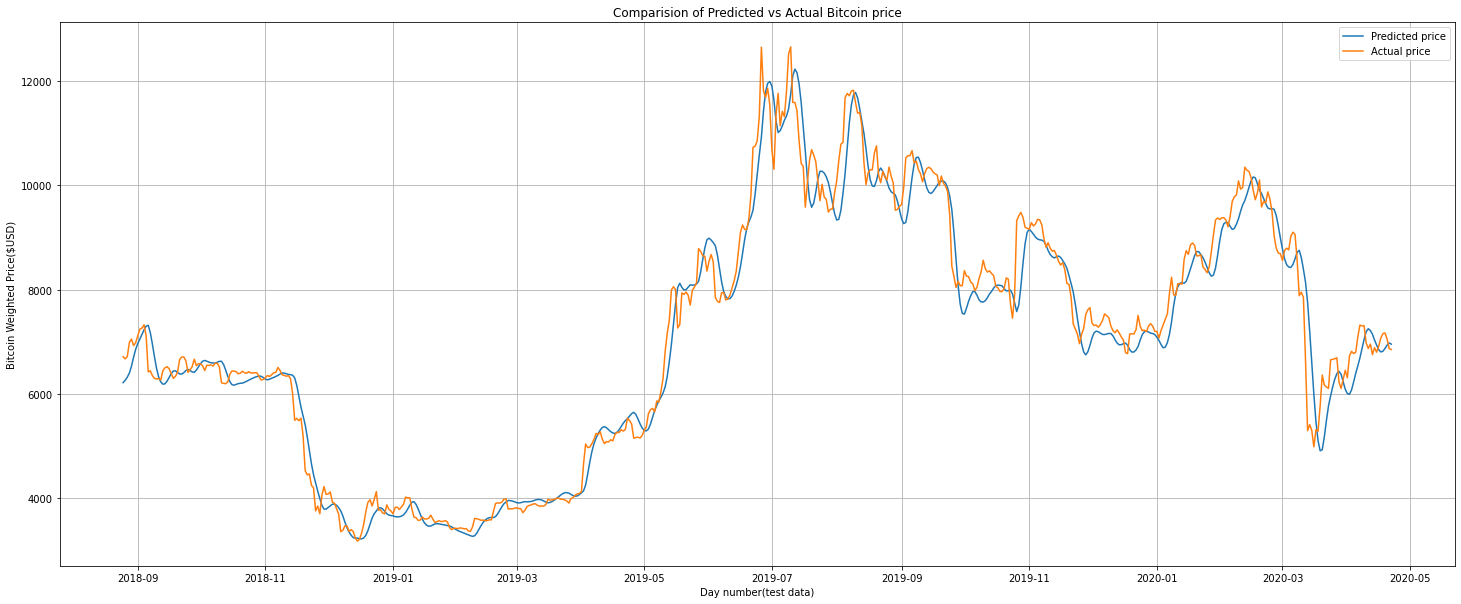

In [ ]:
Prediction_date_range = day_test_df.iloc[prev_val:,0]

plt.figure(figsize=(25,10),facecolor='white')
plt.plot(Prediction_date_range, y_pred2_inverse, label='Predicted price')
plt.plot(Prediction_date_range, y_test2_inverse, label='Actual price')
plt.legend(loc="upper right")
plt.xlabel('Day number(test data)')
plt.ylabel('Bitcoin Weighted Price($USD)')
plt.title('Comparision of Predicted vs Actual Bitcoin price')
plt.grid()

In [ ]:
date = [day_test_df.iloc[-11:,0]]
predicted = y_pred2_inverse[-11:]
Actual = y_test2_inverse[-11:]

print('Below is the table for prediction and comparision for month of April 12th to april 22\n\n\n')

print(date)
print(predicted)
print(Actual)
  


Below is the table for prediction and comparision for month of April



[3025   2020-04-12
3026   2020-04-13
3027   2020-04-14
3028   2020-04-15
3029   2020-04-16
3030   2020-04-17
3031   2020-04-18
3032   2020-04-19
3033   2020-04-20
3034   2020-04-21
3035   2020-04-22
Name: Timestamp, dtype: datetime64[ns]]
[7213.9165 7142.497  7031.413  6934.094  6846.189  6803.2666 6817.889
 6869.909  6934.8936 6975.755  6952.9155]
[6954.06131225 6751.87176591 6884.68698601 6798.84755376 6914.66641015
 7071.90178813 7153.9275586  7166.96847035 7050.52623296 6867.15547559
 6850.6       ]
